# Train agent

All the required codes to train agent are defined in this notebook.
For the running environment setup, see the [README.md](./README.md).

### Define neural network models for agent

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # GPU is not tested.

class A2C(nn.Module):
    """Advantage Actor Critic Model"""

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=128):
        """Initialize parameters and build model.
        
        Parameters
        ----------
            state_size : int
                Dimension of each state
            action_size : int
                Dimension of each action
            seed : int
                Random seed
            fc1_units : int
                Number of nodes in the first hidden layer
            fc2_units : int
                Number of nodes in the second hidden layer
        """

        super(A2C, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        
        # Actor and critic networks share hidden layers
        self.fc_actor = nn.Linear(fc2_units, action_size)
        self.fc_critic = nn.Linear(fc2_units, 1)
        
        # Standard deviation for distribution to generate actions
        self.std = nn.Parameter(torch.ones(action_size))
        
    def forward(self, state):
        """In this A2C model, a batch of state from all agents shall be processed. 
        
        Parameters
        ----------
        state : array_like
            State of agent
        
        Returns
        -------
        value : torch.Tensor
            V value of the current state.
        action : torch.Tensor
            Action generated from the current policy and state
        log_prob : torch.Tensor
            Log of the probability density/mass function evaluated at value.
        entropy : torch.Tensor
            entropy of the distribution
            
        """
        state = torch.tensor(state, device=DEVICE, dtype=torch.float32)
        out1 = F.relu(self.fc1(state))
        out2 = F.relu(self.fc2(out1))
        
        # mean of the Gaussian distribution range in [-1, 1]
        mean = torch.tanh(self.fc_actor(out2))
        # V value
        value = self.fc_critic(out2)
        
        # Create distribution from mean and standard deviation
        # Use softplus function to make deviation always positive
        # SoftPlus is a smooth approximation to ReLU function
        # i.e. softplus(1.0)  = 1.4189
        #      softplus(0.0)  = 0.6931
        #      softplus(-1.0) = 0.3133
        #      softplus(-2.0) = 0.1269
        dist = torch.distributions.Normal(mean, F.softplus(self.std))
        
        # Sample next action from the distribution.
        # [[action_(1,1), action_(1,2), .., action_(1,action_size)],
        #  [action_(2,1), action_(2,2), .., action_(2,action_size)],
        #   ...
        #  [action_(NumOfAgents,1), action_(NumOfAgents,2), .., action_(NumOfAgents,action_size)]]
        action = dist.sample()
        action = torch.clamp(action, min=-1.0, max=1.0)
        
        # Create the log of the probability at the actions
        # Sum up them, and recover 1 dimention
        # --> dist.log_prob(action)
        # [[lp_(1,1), lp_(1,2), .., lp_(1,action_size)],
        #  [lp_(2,1), lp_(2,2), .., lp_(2,action_size)],
        #   ...
        #  [lp_(NumOfAgents,1), lp_(NumOfAgents,2), .., lp_(NumOfAgents,action_size)]]
        # --> sum(-1)
        # [sum_1,sum_2, .., sum_NumOfAgents]
        # --> unsqueeze(-1)
        # [[sum_1],
        #  [sum_2],
        #   ...
        #  [sum_NumOfAgents]]
        # Todo: Check theory of multiple actions. Is it okay to sum up?
        log_prob = dist.log_prob(action).sum(-1).unsqueeze(-1)

        # When std is fixed, entropy is same value.
        entropy = dist.entropy().sum(-1).unsqueeze(-1)
        
        return value, action, log_prob, entropy

### Define environment and agent

In [2]:
from unityagents import UnityEnvironment
import gym
import numpy as np
import random

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

GAMMA = 0.99            # discount factor
LR = 5e-4               # learning rate 

class BallTrackEnv():
    """Reacher environment"""
    
    def __init__(self, seed = 0):
        """Initialize environment."""

        env = UnityEnvironment(file_name='Reacher.app', seed=seed)
        self.env = env
        self.brain_name = env.brain_names[0]
        self.brain = env.brains[self.brain_name]
        self.env_info = self.env.reset(train_mode=True)[self.brain_name]
        
        self.action_size = self.brain.vector_action_space_size
        print('Size of action:', self.action_size)
        
        states = self.env_info.vector_observations
        self.state_size = states.shape[1]
        print('Size of state:', self.state_size)
        
        self.num_agents = len(self.env_info.agents)
        print('Number of agents:', self.num_agents)
        
    def reset(self, train_mode = True):
        """Reset environment and return initial states. 
        
        Returns
        -------
        state : numpy.ndarray
            Initial agents' states of the environment (20 agents x 33 states)
            
        """
        self.env_info = self.env.reset(train_mode)[self.brain_name]
        return self.env_info.vector_observations
        
    def one_step_forward(self, actions):
        """Take one step with actions. 
        
        Parameters
        ----------
        actions : numpy.ndarray
                Agents' actions a_t (20 agents x 4 actions)
        
        Returns
        -------
        new_states : numpy.ndarray of numpy.float64
            New states s_(t+1)
        rewards : list of float
            Rewards r(t)
        dones : list of bool
            True if a episode is done
        """
        self.env_info = self.env.step(actions)[self.brain_name]
        new_states = self.env_info.vector_observations
        rewards = self.env_info.rewards
        dones = self.env_info.local_done
        return new_states, rewards, dones
    def close(self):
        self.env.close()

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, env, seed):
        """Initialize an Agent object.
        
        Parameters
        ----------
        env : BallTrackEnv
            environment for the agent to interacts
        seed : 
            random seed
        
        Returns
        -------
        new_states : numpy.ndarray
            New states s_(t+1)
        rewards : list
            Rewards r(t)
        dones : list
            True if a episode is done
        """
        
        self.env = env
        self.state_size = env.state_size
        self.action_size = env.action_size
        self.seed = random.seed(seed)
        
        self.a2c = A2C(self.state_size, self.action_size, seed).to(DEVICE)
        self.optimizer = optim.Adam(self.a2c.parameters(), lr=LR)
        
        self.log_probs = []
        self.values = []
        self.rewards = []
        
        self.episode_score = 0
        
        self.rollout = 5
        
        self.actor_loss = 0.0
        self.critic_loss = 0.0
        self.entropy = 0.0
        self.loss = 0.0
        
        self.critic_loss_coef = 3.0
    
    def collet_experiences(self, state, step, num_steps):
        """Collect experiences for the number of rollout
        
        Parameters
        ----------
        state : numpy.ndarray (20 x 33)
            Initial states
        step : 
            Curret step
        num_steps : 
            Maximum number of steps for an episode
        
        Returns
        -------
        rewards : list
            Rewards r(t)
        dones : list
            True if a episode is done
        values : list of torch.Tensor
            V values
        log_probs : list of torch.Tensor
            Log of the probability density/mass function evaluated at value.   
        entropys : list of torch.Tensor
            entropy of the distribution
        step : int
            current step
        state: numpy.ndarray (20 x 33)
            Current states
        episode_done : bool
            If episode is done, True
        """
        rewards = []
        dones = []
        values = []
        log_probs = []
        entropys = []
        
        for rollout in range(self.rollout):
            
            value, action, log_prob, entropy = self.a2c.forward(state)
            new_state, reward, done = self.env.one_step_forward(action.detach().squeeze().numpy())

            self.episode_score += np.sum(reward)/self.env.num_agents # accumulate mean of rewards
            reward = torch.tensor(reward).unsqueeze(-1)

            rewards.append(reward)
            dones.append(done)
            values.append(value)
            log_probs.append(log_prob)
            entropys.append(entropy)

            state = new_state

            episode_done = np.any(done) or step == num_steps-1

            if episode_done or rollout == self.rollout-1:
                step += 1
                break

            step += 1
        return rewards, dones, values, log_probs, entropys, step, state, episode_done
    
    def learn(self, state, rewards, dones, values, log_probs, entropys):
        """Learn from collected experiences
        
        Parameters
        ----------
        state : numpy.ndarray (20 x 33)
            Current states
        rewards : list
            Rewards r(t)
        dones : list
            True if a episode is done
        values : list of torch.Tensor
            V values
        log_probs : list of torch.Tensor
            Log of the probability density/mass function evaluated at value.   
        entropys : list of torch.Tensor
            entropy of the distribution
        
        Returns
        -------
        none
        """
        
        length = len(rewards)
        
        # Create area to store advantages and returns over trajectory
        advantages = [torch.FloatTensor(np.zeros((self.env.num_agents, 1)))]*length
        returns = [torch.FloatTensor(np.zeros((self.env.num_agents, 1)))]*length
        
        # Caclculate V(t_end+1)
        value, _, _, _ = self.a2c.forward(state)
        # Set V(t_end+1) to temporal return value
        _return = value.detach()
        
        # Calculate advantages and returns backwards
        for i in reversed(range(length)):
            # Return(t) = reward(t) + gamma * Return(t+1) if not last step
            _return = rewards[i] + GAMMA * _return * torch.FloatTensor(1 - np.array(dones[i])).unsqueeze(-1)
            # Advantage(t) = Return(t) - Value(t)
            advantages[i] = _return.detach() - values[i].detach()
            returns[i] = _return.detach()

        # Flatten all agents results in one list
        log_probs = torch.cat(log_probs, dim=0)
        advantages = torch.cat(advantages, dim=0)
        returns = torch.cat(returns, dim=0)
        values = torch.cat(values, dim=0)
        entropys = torch.cat(entropys, dim=0)

        # Calculate losses
        self.actor_loss = -(log_probs * advantages).mean()
        self.critic_loss = (0.5 * (returns - values).pow(2)).mean()
        self.entropy = entropys.mean()
        
        # Sum-up all losses with weights
        self.loss = self.actor_loss + self.critic_loss_coef * self.critic_loss - 0.001 * self.entropy
        
        # Update model
        self.optimizer.zero_grad()
        self.loss.backward()
        self.optimizer.step()
    
    def run_episode(self, num_steps):
        """Initialize an Agent object.
        
        Parameters
        ----------
        num_steps : int
            maximum steps of one episode
        show_result : 
            random seed
        
        Returns
        -------
        episode_reward : float
            Mean of total rewards that all agents collected
        """
        state = self.env.reset()
        
        self.episode_score = 0
        episode_done = False      
        step = 0
        
        while not episode_done:
            rewards, dones, values, log_probs, entropys, step, state, episode_done = self.collet_experiences(state, step, num_steps)
            self.learn(state, rewards, dones, values, log_probs, entropys)
        return self.episode_score
    
    def save(self, filename):
        torch.save(self.a2c.state_dict(), filename)

    def load(self, filename):
        state_dict = torch.load(filename, map_location=lambda storage, loc: storage)
        self.a2c.load_state_dict(state_dict)

### Train agent
Sample output:
```
Size of action: 4
Size of state: 33
Number of agents: 20
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Linear-1               [-1, 1, 128]           4,352
            Linear-2               [-1, 1, 128]          16,512
            Linear-3                 [-1, 1, 4]             516
            Linear-4                 [-1, 1, 1]             129
================================================================
Total params: 21,509
Trainable params: 21,509
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.08
Estimated Total Size (MB): 0.08
----------------------------------------------------------------
episode, 	score, 	total_loss, 	actor_loss, 	critic_loss, 	entropy
1, 	0.1695, 	0.0073, 	0.2254, 	0.0073, 	6.7658
2, 	0.0640, 	0.0007, 	-0.0526, 	0.0007, 	6.7658
3, 	0.1455, 	0.0005, 	-0.0927, 	0.0005, 	6.7658
4, 	0.1285, 	0.0003, 	0.0020, 	0.0003, 	6.7658
5, 	0.1435, 	0.0002, 	-0.0154, 	0.0002, 	6.7658
6, 	0.0620, 	0.0002, 	-0.0384, 	0.0002, 	6.7658
7, 	0.1350, 	0.0005, 	-0.1349, 	0.0005, 	6.7658
8, 	0.0565, 	0.0001, 	0.0107, 	0.0001, 	6.7658
9, 	0.0460, 	0.0002, 	0.0019, 	0.0002, 	6.7658
10, 	0.0810, 	0.0001, 	0.0102, 	0.0001, 	6.7658
```

In [ ]:
from torchsummary import summary

seed = 1
env = BallTrackEnv()
agent = Agent(env, seed)

summary(agent.a2c, (1, agent.state_size, 0))

max_episodes = 200
num_steps = 10000 # The maximum steps of the environement is 1000. Thus this parameter does nothing.
print("episode, \tscore, \ttotal_loss, \tactor_loss, \tcritic_loss, \tentropy")
for i in range(max_episodes):
    episode = i + 1
    episode_score = agent.run_episode(num_steps)
    if episode % 1 == 0:
        print("{}, \t{:.4f}, \t{:.4f}, \t{:.4f}, \t{:.4f}, \t{:.4f}".format(episode, episode_score, agent.loss, agent.actor_loss, agent.critic_loss, agent.entropy))
    if episode % 50 == 0 and episode != 0:
        agent.save("check_point_{}".format(episode))

### Plot trained result

At 73 episode A2C achieved score 30.0
At 151 episode A2C achieved average score 30.0


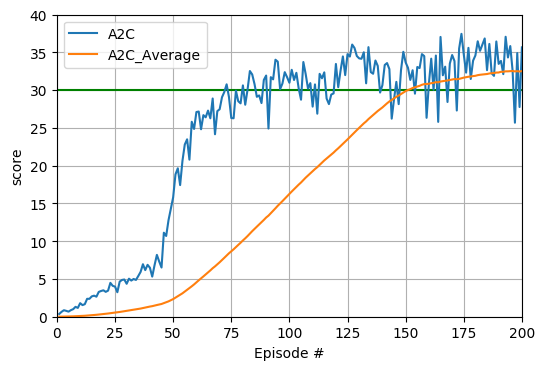

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
def plotScore(data_paths):
    plt.rcParams["figure.dpi"] = 100.0

    num=100
    b=np.ones(num)/num
    a = np.zeros(num-1)

    for path in data_paths:
        data = np.loadtxt(path[1], skiprows=1, usecols=1, delimiter=', \t', dtype='float')
        length = len(data)
        data_mean = np.convolve(np.hstack((a, data)), b, mode='vaild')
        print('At '+ str(np.where(data > 30.0)[0][0] + 1), 'episode', path[0], 'achieved score 30.0')
        print('At '+ str(np.where(data_mean > 30.0)[0][0] + 1), 'episode', path[0], 'achieved average score 30.0')
        plt.plot(np.linspace(1, length, length, endpoint=True), data, label=path[0])
        plt.plot(np.linspace(1, length, length, endpoint=True), data_mean, label=path[0]+"_Average")
    
    plt.xlabel('Episode #')
    plt.ylabel('score')
    plt.legend()
    plt.xlim(0, length)
    plt.ylim(0.0, 40.0)
    plt.grid()
    plt.hlines([30.0], 0, length, "green")
    plt.show()

data_paths = []
data_paths.append(['A2C','results/critic3_en-3_std1.txt'])
plotScore(data_paths)

### Watch trained agent and take screenshots

In [3]:
from PIL import ImageGrab
take_screenshot = False

# Watch trained agent
seed = 100
env = BallTrackEnv(seed)
agent = Agent(env, seed)
agent.load('results/check_point_200_critic3_en-3')

# softplus(-100) = 1.00000e-44 * 3.7835, which means nearly determistic
agent.a2c.std = nn.Parameter(-100*torch.ones(agent.action_size))

state = agent.env.reset(train_mode=False) # reset the environment and get the initial state
score = np.zeros(agent.env.num_agents)    # initialize the score
step = 0
while True:
    _, action, _, _ = agent.a2c.forward(state)    # select an action
    new_state, reward, done = agent.env.one_step_forward(action.detach().squeeze().numpy())
    score = score + reward
    state = new_state
    if take_screenshot:
        if step % 1  == 0: # create screenshot in each step
            filename = "results/step" + str(step) + ".png" 
            ImageGrab.grab(bbox=(0, 88, 1280, 804)).save(filename) #Screenshot area to be adjusted in your environment
    step += 1
    if np.any(done):
        break

print("Score of each agent: {}".format(score))
print("Average score: {}".format(np.sum(score)/agent.env.num_agents))
agent.env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Size of action: 4
Size of state: 33
Number of agents: 20
Score of each agent: [39.54999912 35.19999921 39.57999912 39.33999912 39.37999912 34.63999923
 39.59999911 39.30999912 39.47999912 39.63999911 39.36999912 39.61999911
 39.57999912 35.21999921 39.55999912 39.38999912 39.58999912 39.67999911
 39.52999912 39.66999911]
Average score: 38.84649913171306


### Visualize network structure by [graphviz library](https://graphviz.readthedocs.io)

In [ ]:
# pip install graphviz
# conda install python-graphviz

import torch
from torchviz import make_dot

seed = 1
env = BallTrackEnv()
agent = Agent(env, seed)

x = agent.env.reset(train_mode=False)
out = agent.a2c(x)

dot = make_dot(out, params=dict(agent.a2c.named_parameters()))
dot.format = 'png'
dot.render('content/model')

agent.env.close()